|  [National Science Data Fabric](https://nationalsciencedatafabric.org/) | [WIRED Global Center](https://resilience.utah.edu/) | [NASA Open Climate Workbench (OCW)](https://esto.nasa.gov/forums/estf2024/estf24Abstracts/lee.html)  |
|:---:|:---:|:---:|
|![nsdf](NSDF-smaller.png) | ![NASA](NASA.png) | ![wired](wired-logo-small.png) |

## Uncomment the line below if any library is missing

In [1]:
#!pip install --upgrade openvisuspy xarray openvisuspy  matplotlib

In [2]:
import os,sys
import numpy as np
import openvisuspy as ovp
import OpenVisus as ov

os.environ["VISUS_CACHE"]=os.environ.get("VISUS_CACHE","./visus_cache_can_be_erased")
print("VISUS_CACHE is ",os.environ["VISUS_CACHE"])

# if you want interactive plots
use_plotly=True 
use_plotly=False

# //////////////////////////////////////////////////////////
def ShowPlot(x, ys, ylabels=[], xaxis_title='',yaxis_title='', title=""):
    if use_plotly:
        import plotly.graph_objects as go
        fig = go.Figure()
        for y,label in zip(ys,ylabels):
            fig.add_trace(go.Scatter(x=x,y=y,name=label))
        fig.update_layout(title=title,xaxis_title=xaxis_title,yaxis_title=yaxis_title, height=800, legend=dict( yanchor="top", y=0.99,  xanchor="left", x=0.01))
        fig.layout.dragmode='pan'
        fig.show(config=dict({'scrollZoom': True,'displayModeBar': False}))
    else:
        fig, ax = plt.subplots(figsize=(18,9))
        for y,label in zip(ys,ylabels):
            ax.plot(x, y , label = label)
        ax.legend() 
        ax.set(xlabel=xaxis_title, ylabel=yaxis_title, title=title)
        ax.grid()
        folder = "./images/"
        plt.savefig(folder + "NEX-GDDP-CMIP6_ACCESS_temperature_trend.png")
        plt.show()


VISUS_CACHE is  ./visus_cache_can_be_erased


day=01 January/quality=0   :   0%|          | 0/150 [00:00<?, ?it/s]

day=01 January/quality=-2   :   0%|          | 0/150 [00:00<?, ?it/s]

day=01 January/quality=-4   :   0%|          | 0/150 [00:00<?, ?it/s]

day=01 January/quality=-6   :   0%|          | 0/150 [00:00<?, ?it/s]

day=01 January/quality=-8   :   0%|          | 0/150 [00:00<?, ?it/s]

day=01 January/quality=-10   :   0%|          | 0/150 [00:00<?, ?it/s]

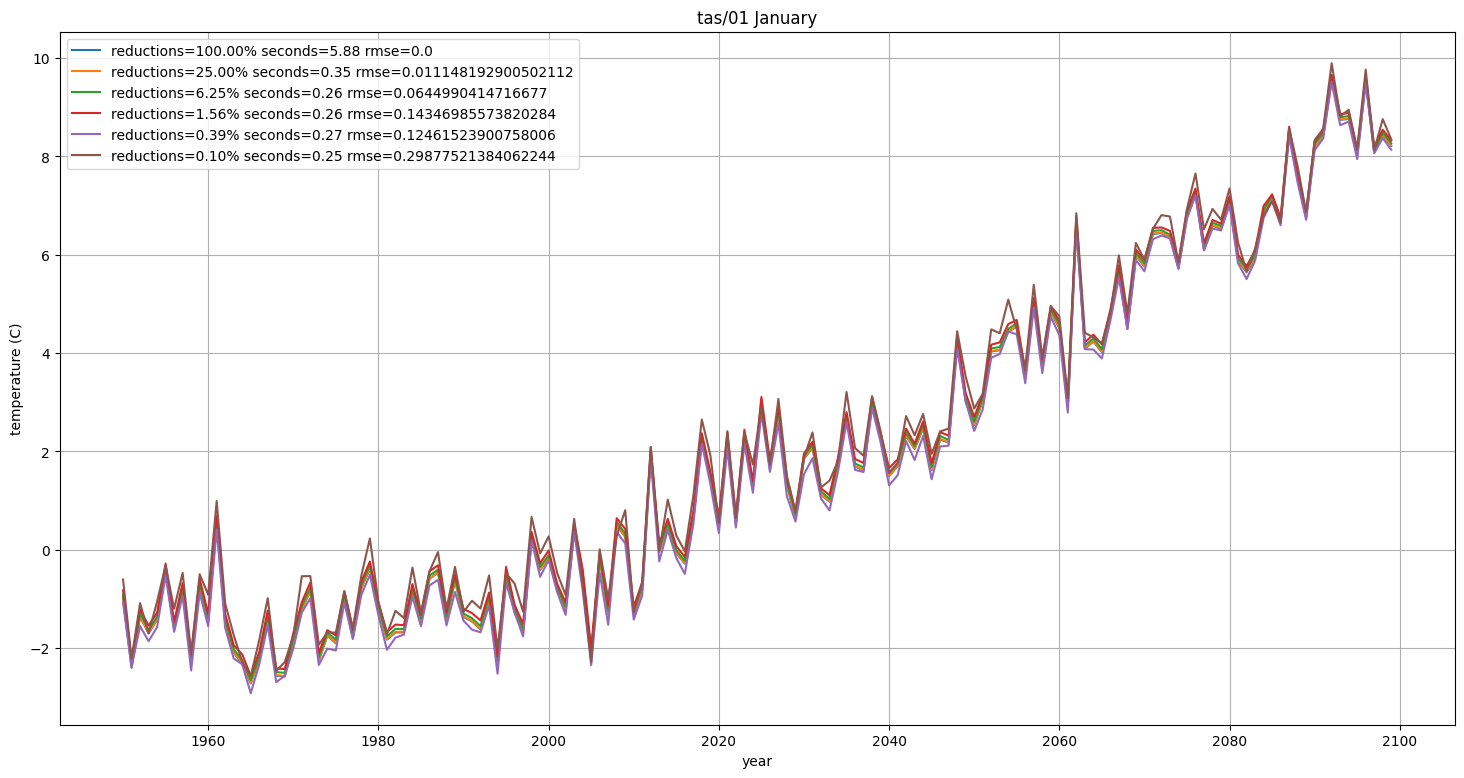

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.notebook import tqdm
from datetime import datetime, timedelta

# run multiple threads
from tqdm.contrib.concurrent import thread_map

variables = {
    "hurs":    "Near-Surface Relative Humidity",
    "huss":    "Near-Surface Specific Humidity",
    "pr":      "Precipitation",
    "rlds" :   "Surface Downwelling Longwave Radiation",
    "rsds":    "Surface Downwelling Shortwave Radiation",
    "sfcWind": "Daily-Mean Near-Surface Wind Speed",
    "tas":     "Daily Near-Surface Air Temperature",
    "tasmax":  "Daily Maximum Near-Surface Air Temperature",
    "tasmin":  "Daily Minimum Near-Surface Air Temperature"
}

# configure as needed
variable = "tas"
field_hist=f"{variable}_day_ACCESS-CM2_historical_r1i1p1f1_gn"
field_model=f"{variable}_day_ACCESS-CM2_ssp585_r1i1p1f1_gn"
db=ov.LoadDataset(f"http://atlantis.sci.utah.edu/mod_visus?dataset=nex-gddp-cmip6&cached=arco")
years=list(range(1950,2100))

# every 30 days
days=[day for day in range(0,365,3000)]

# Lower the quality until it goes too far
qualities=[0,-2,-4,-6,-8,-10] 

# //////////////////////////////////////////////////////////
for day in days:
    day_name=(datetime(year=2015, month=1, day=1) + timedelta(days=day)).strftime('%d %B')
    ys,ylabels=[],[]
    y0=None
    for quality in qualities:
        t0 = time.time()
        data=db.read(field=field_hist,quality=quality) # here always history?
        num_vals = (data.size)- np.isnan(data).sum()
        def GetTemperature(year):
            field_now=field_hist if year<2015 else field_model
            data=db.read(time=year*365+day ,field=field_now,quality=quality)
            return np.nansum(data)/num_vals-273.15
        y=thread_map(GetTemperature, years, desc=f"day={day_name}/quality={quality}   ")
        ys.append(y)
        if quality==0: y0=y
        rmse=np.sqrt(np.nanmean(np.square(np.subtract(y, y0))))
        ylabels.append(f"reductions={1/2**(-1*quality):.02%} seconds={time.time()-t0:.02f} rmse={rmse}")
        
    ShowPlot(x=years, ys=ys, ylabels=ylabels, xaxis_title='year', yaxis_title='temperature (C)', title=f"{variable}/{day_name}")
